In [1]:
# %matplotlib ipympl 
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [69]:
# load all data into dataframe
def load_data(path, file_names, aliases):
    dates = {}
#     path = 'C:\\Users\\plant\\OneDrive\\Documents\\Neural Networks Project\\'
#     file_name_SP = 'SandPPrices'  
#     file_name_RE = 'RealEstateIndexDailySince2013'

    data_files = [file_name_SP, file_name_RE]
    aliases = ["sp", "re"]
    for data_set_idx in range(len(data_files)):
        cur_alias = aliases[data_set_idx]
        with open(path + data_files[data_set_idx] + '.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            spamreader.__next__()
            for row in spamreader:
                try:
                    cur_date = datetime.datetime.strptime(row[0], '%m/%d/%Y')

                except:
                   continue
                if not cur_date in dates:
                    dates[cur_date] = {}
                if data_set_idx == 0:
                    dates[cur_date][cur_alias] = float(row[4])
                elif data_set_idx == 1:
                    dates[cur_date][cur_alias] = float(row[1])

    frame = pd.DataFrame.from_dict(dates, orient='index')
    frame.columns = aliases
    frame.reset_index(inplace=True)
    frame = frame.rename(columns = {'index':'Date'})
    return frame


In [70]:
path = 'C:\\Users\\plant\\OneDrive\\Documents\\Neural Networks Project\\'
file_name_SP = 'SandPPrices'  
file_name_RE = 'RealEstateIndexDailySince2013'

data_files = [file_name_SP, file_name_RE, file_name_SP]
aliases = ["sp", "re", "sp"]

frame = load_data(path, data_files, aliases)

In [68]:
frame

,Date,sp,re
0,2000-01-03,1455.22,NaN
1,2000-01-04,1399.42,NaN
2,2000-01-05,1402.11,NaN
3,2000-01-06,1403.45,NaN
4,2000-01-07,1441.47,NaN
...,...,...,...
5839,2023-02-15,NaN,357.06
5840,2023-02-16,NaN,353.84
5841,2023-02-17,NaN,352.45
5842,2023-02-21,NaN,345.51


In [5]:
not_null = frame.query("sp.notnull() and re.notnull()")
not_null.reset_index(drop = True, inplace = True)
not_null

,Date,sp,re
0,2013-01-31,1498.11,261.09
1,2013-02-01,1513.17,262.48
2,2013-02-04,1495.71,261.94
3,2013-02-05,1511.29,261.73
4,2013-02-06,1512.12,262.26
...,...,...,...
2493,2022-12-23,3844.82,330.11
2494,2022-12-27,3829.25,329.80
2495,2022-12-28,3783.22,324.33
2496,2022-12-29,3849.28,330.75


In [6]:
sp_prev_month = []
re_prev_month = []
sp_next_2wks = []
re_next_2wks  = []


for idx, row in not_null.iterrows():
    if idx + 10 < not_null.shape[0] and idx > 20:
        sp_cur = row['sp']
        sp_last_month = not_null.loc[idx - 21].at['sp']
        sp_fut_2wk = not_null.loc[idx + 10].at['sp']
        re_cur = row['re']
        re_last_month = not_null.loc[idx - 21].at['re']
        re_fut_2wk = not_null.loc[idx + 10].at['re']
        sp_prev_month.append((sp_cur - sp_last_month)/sp_last_month)
        re_prev_month.append((re_cur - re_last_month)/re_last_month)
        sp_next_2wks.append((sp_fut_2wk - sp_cur)/sp_cur)
        re_next_2wks.append((re_fut_2wk - re_cur)/re_cur)
    else:
        sp_prev_month.append(None)
        re_prev_month.append(None)
        re_next_2wks.append(None) 
        sp_next_2wks.append(None)
        
not_null = not_null.assign(sp_last_month = sp_prev_month)
not_null = not_null.assign(re_last_month = re_prev_month)
not_null = not_null.assign(sp_fut_2wks = sp_next_2wks)
not_null = not_null.assign(re_fut_2wks = re_next_2wks)
not_null["re_sp_2wk_diff"] = not_null["re_fut_2wks"]  - not_null["sp_fut_2wks"]
not_null.iloc[40:41]

,Date,sp,re,sp_last_month,re_last_month,sp_fut_2wks,re_fut_2wks,re_sp_2wk_diff
40,2013-04-01,1562.17,270.57,0.031353,0.02613,-0.00628,0.015892,0.022172


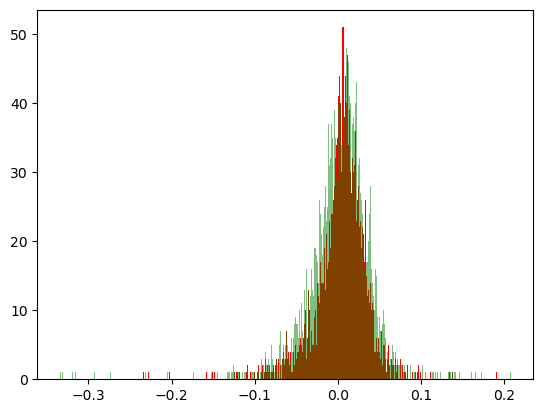

In [7]:
plt.figure()
plt.hist(not_null['sp_fut_2wks'], color = 'red', bins = 500)
plt.hist(not_null['re_fut_2wks'], color = 'green', bins = 500, alpha = .5,)
plt.show()

In [8]:
# fig = plt.figure()
# ax = fig.add_subplot(projection = '3d')

# ax.scatter(not_null["sp_last_month"], not_null["re_last_month"], not_null["re_sp_2wk_diff"])
# ax.set_xlabel('sp_last_month')
# ax.set_ylabel('re_last_month')
# ax.set_zlabel('re_sp_2wk_diff')
# plt.show()

In [9]:
not_null = not_null.query("sp_last_month.notnull() and re_last_month.notnull() and re_sp_2wk_diff.notnull()")
variables = [not_null["sp_last_month"], not_null["re_last_month"], not_null["re_sp_2wk_diff"]]
cov_mat = np.cov(variables)
cov_mat


array([[ 1.93105470e-03,  1.74923916e-03,  5.73594980e-05],
       [ 1.74923916e-03,  2.79349905e-03, -8.65065117e-05],
       [ 5.73594980e-05, -8.65065117e-05,  6.56947028e-04]])

[0.009290984781652004, 0.003673454996762879, -0.0025899889074530234]
(400, 400, 400)


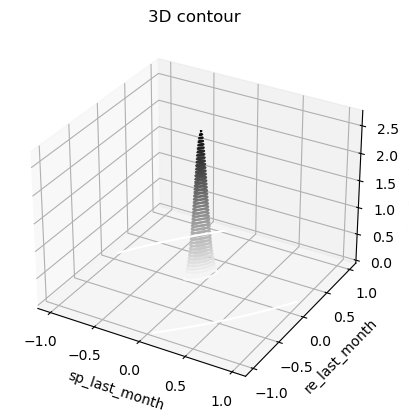

In [50]:
means = [np.mean(not_null["sp_last_month"]), np.mean(not_null["re_last_month"]), np.mean(not_null["re_sp_2wk_diff"])]
print(means)
rv = multivariate_normal(mean=means, cov=cov_mat, allow_singular=False)

x, y, z= np.mgrid[-1:1:.005, -1:1:.005,  -1:1:.005]
print(y.shape)
pos = np.stack((x, y, z), axis = 3)
# print(pos[:, :, 99:100, :].shape)
# print(rv.pdf(pos[99:100, :, :, :]).shape)
# print(rv.pdf(pos[99:100, :, :, :]))
x, y= np.mgrid[-1:1:.005, -1:1:.005]
fig = plt.figure()
ax = plt.axes(projection='3d')
# print( np.max(rv.cdf(pos[100:101, :, :, :])))
ax.contour3D(x,  y, rv.pdf(pos[:, :, 100:101, :]), 50, cmap='binary')
ax.set_xlabel('sp_last_month')
ax.set_ylabel('re_last_month')
ax.set_zlabel('re_sp_2wk_diff')
ax.set_title('3D contour')
plt.show()

# fig2 = plt.figure()
# ax2 = fig2.add_subplot(111)
# ax2.contourf(x, y, rv.pdf(pos))


(200, 200, 2)
(200, 200)


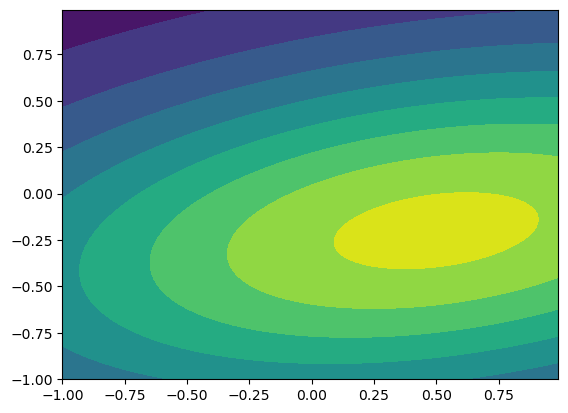

In [11]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
print(pos.shape)
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
print(rv.pdf(pos).shape)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))